# Titanic : Tutorial
### 参考記事「Kaggleに登録したら次にやること ～ これだけやれば十分闘える！Titanicの先へ行く入門 10 Kernel ～」
Link : https://qiita.com/upura/items/3c10ff6fed4e7c3d70f0

このnotebookはversion2です.version1を見てない場合はversion1を先に見ましょう.versionの切り替えは https://www.kaggle.com/yudai0731/titanic-tutorial の右上青字のversionから切り替えることができます. version2ではversion1のnotebookを改良し,より精度の高いモデルを作成します.

## 1. まずはsubmit! 順位表に載ってみよう
kaggleではいつくかの方法で自分が作成した機械学習モデルの予測結果を提出(submit)できる(Notebook経由のみのコンペもあり).
* Notebook経由
* csvファイルを直接アップロード
* Kaggle APIを利用

## 2 全体像を把握！ submitまでの処理の流れを見てみよう
具体的な処理の流れ
1. パッケージの読み込み
2. データの読み込み
3. 特徴量エンジニアリング(Feature Engineering)
4. 機械学習アルゴリズムの学習・予測
5. 提出

### パッケージの読み込み
以降の処理で利用するパッケージの読み込みを行う.

In [14]:
import numpy as np # road matrix calculation library 
import pandas as pd # road data analysis library 
import seaborn as sns # road visualization library 
import matplotlib.pyplot as plt # road visualization library 

### データの読み込み
kaggleから提供されているデータを読み込む.
データの詳細はkaggleのコンペティションのページの「Data」タブや,右上のDataの項目から見ることができる.  
train.csvは機械学習の訓練用のデータです.test.csvは予測を実施するデータです.gender_submission.csvは提出のサンプルです.このファイルを見ると,提出ファイルの形式を確認できます.  
head関数を用いて実際にデータが読み込めていることを確認します.``train.head()``の実行結果を見ると,Pclass(搭乗しているクラス)やName(名前)など乗客一人一人の情報が表になっていることがわかります.
このコンペで予想するのはtestデータのSurvived(0:死亡,1:生存)という項目です.確認のために,``test.head()``の結果を見ると``Survived``の項目がないことがわかります.また``gender_submission.head()``
の実行結果を見ると``PassengerId``と``Survived``が記述されています.  
  
データをもう少し詳しくみると,``Name``や``Sex``などは文字列が格納されているため,そのままでは機械学習アルゴリズムの入力にすることができません.これらは機械学習アルゴリズムが扱える
形に変換する必要があります.また,``Nan``というのはデータの欠損です.欠損値は,一部の機械学習アルゴリズムではそのまま扱うこともできますが,代表値で穴埋めする場合もあります.

In [15]:
PATH = '../input/titanic/' # set PATH string
train = pd.read_csv(PATH+'train.csv') # read train data(csv)
test = pd.read_csv(PATH+'test.csv') # read train(csv)
gender_submission = pd.read_csv(PATH+'gender_submission.csv') # read submit sample

In [16]:
# 実際に読み込めているか確認
train.head() # trainの先頭5行を表示

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [17]:
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [18]:
gender_submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


### 特徴量エンジニアリング
次のような処理を特徴量エンジニアリングという.
* 読み込んだデータを機械学習アルゴリズムが扱える形に変換する.
* 既存のデータから,機械学習アルゴリズムが予測する上で有用な新しい特徴量を生成する.
前者については,例えば``Sex``の``male``,``female``をそれぞれ0と1に変換します.また欠損値を埋める処理も行います.後者については次のNotebookで詳しく掘り下げていきます.  
  
大元のデータから特徴量エンジニアリングを経て,X_train,y_train,X_testというデータを作ります.大雑把な表現をすると,X_train,y_trainの対応関係を学習し,
X_testに対応する(未知の)y_testの値を当てるという仕組みです.このような仕組みを「教師あり学習」と呼びます.(cf.教師なし学習)

## 3. ここで差がつく！ 仮説に基づいて新しい特徴量を作ってみよう
3~7章ではversion1のnotebookに手を加えながらスコアを上げる方法を学んでいきます.

### 再現性の大切さ
「再現性がある」とは,何度実行しても同じ結果が得られることです.kaggleでいうと同一スコアが得られることと言い換えられます.再現性がないと結果ごとに異なるスコアが得られてしまいます.
今後,特徴量エンジニアリングなどでスコアの向上を試みても,予測モデルが改善されたか否かを正しく判断できなくなる問題が生じます.  
  
(欠損値を乱数で埋めてしまうと再現性がなくなってしまう例)
version1では欠損値があるためAgeを用いませんでしたが,年齢も乗客の生死を判断するうえで重要な特徴量です.ここでは欠損値を埋める方法を埋める方法を考えます.
下のプログラムのように乱数でAgeの欠損値を埋めると再現性がなくなってしまいます.
```python
age_avg = data['Age'].mean() #mean of Age(mean:算術平均)
age_std = data['Age'].std() # std of Age(std:標準偏差)
data['Age'].fillna(np.random.randint(age_avg - age_std, age_avg + age_std), inplace=True) #欠損値を平均から幅stdの範囲の整数乱数で埋める
```

再現性を確保する方法として,例えば次のような方法が考えられます.
1. そもそも乱数を用いて部分を削除する.
2. 乱数のseedを与えて実行結果を固定する.

Ageについては乱数を用いるより欠損していないデータの中央値(median)を与えた方が筋の良い補完ができそうです.ここでは中央値で補完するコードを追加します.

In [37]:
dataset = pd.concat((train,test),ignore_index=True) # concat train and test
# print(pd.isnull(dataset).sum()) # the number of missing values in each feature
dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median()) # fill missing value in Age(median)
dataset.replace(['male','female'], [0, 1], inplace=True) # convert Sex into numbers
dataset['Embarked'] = dataset['Embarked'].fillna('S') # fill missing value in Embarked(mode)
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].mean())
dataset.replace(['S','C','Q'], [0, 1,2], inplace=True) # convert Embarked into numbers
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,NaN,0,2.0,0.0
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,C85,1,2.0,0.0
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,NaN,0,1.0,1.0
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,C123,0,2.0,0.0
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,NaN,0,1.0,1.0


In [38]:
pd.isnull(dataset).sum() # 欠損値がなくなったことを確認するコード 特徴量と欠損値の数が表示される

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age               0
SibSp             0
Parch             0
Ticket            0
Fare              0
Cabin          1014
Embarked          0
FamilySize      418
IsAlone         418
dtype: int64

### 仮説から新しい特徴量を作る
ここでは,仮説と可視化から新しい特徴量を作る過程をまとめます.予測精度に寄与する新しい特徴量を製作るにあたっては,仮説と可視化を繰り返すサイクルが大切だと思います.
* 予測精度に寄与しそうな仮説を立てる.
* 可視化を実施する
    - 予測精度に寄与する仮設を見つけるため
    - 仮説が正しいか検証するため
    
### ケース1) ドメイン知識がある場合
自分が詳しい,つまりドメイン知識を持っている分野の問題に取り組む場合,最初から仮説がいくつかあると思います.その場合は仮説を検証するような可視化を実施し,本当に予測精度に寄与するかを確認します.
可視化の結果によっては,改めて仮説を立てることになるかもしれません.

### ケース2) ドメイン知識がない場合
ドメイン知識がない場合は,まず仮説を立てるための探索的データ分析(EDA : Explore Data Analysis)を実施することになるでしょう.いろいろな軸でデータを眺め,予測精度に寄与しそうな仮説を立てるのが
目的になります.  
  
実際に新しい特徴量を作ってみましょう.例として,EDAを実施した結果,ぼんやりと「一緒に乗船した家族の人数が多い方が,生存率が低そうだ」という仮説が得られた状況を考えます.
仮説が得られたので次はこの仮説を検証するための可視化に移ります.version1で説明しませんでしたがそれぞれの特徴量の概要や意味についてはkaggleのコンペティションのページの「Data」タグに
記述があります(英語).ざっくりですが特徴量の意味は次のとおりです.
- PassengerID : 乗客の番号,予測には用いない
- Survived : ターゲット,乗客の生死,生存1/死亡0
- Pclass : 乗船していたクラス(1st,2nd,3rd)
- Name : 乗客の名前
- Sex : 乗客の性別(male,female)
- Age : 乗客の年齢
- SibSp : タイタニックに乗船していた兄弟,配偶者の人数
- Parch : タイタニックに乗船していた両親,子供の人数
- Ticket : チケット
- Fare : 乗船運賃
- Cabin : キャビン番号
- Embarked : 乗船した港(C,Q,S)
  
今回の仮説では``SibSp``と``Parch``が関係しそうです.
``FamilySize``という新しい行を作り,その大きさごとに生存したか否かを棒グラフにしました.

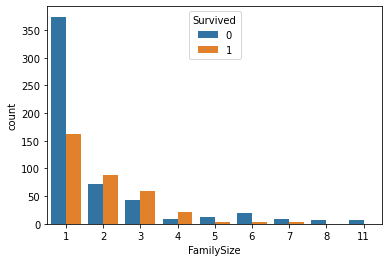

In [39]:
dataset['FamilySize'] = dataset['Parch'] + dataset['SibSp'] + 1 # 'FamilySize = 兄弟,配偶者の塔乗数+両親,子供の塔乗数+自分(1)
train['FamilySize'] = dataset['FamilySize'][:len(train)]
test['FamilySize'] = dataset['FamilySize'][len(train):]
plt.figure(facecolor="white")
sns.countplot(x='FamilySize', data=train, hue='Survived')

``FamilySize``が5以上の時,死亡が生存を上回っており,生存率が低いことがわかります.「一緒に乗船した家族の人数が多い方が,生存率が低そうだ」というぼんやりした仮説が,
可視化を通じて「``FamilySize``が5以上の場合,生存率が低いので,この特徴量は予測精度に寄与しそうだ」という確信をもった仮説に変わりました.  
  
更に,今回の可視化を通じて「``FamilySize``が1の人が圧倒的に多く,生存率が低い」という新しい仮説を得ることもできました.
この``FamilySize``が1という特徴量も予測精度に寄与しそうなので,新しく``IsAlone``という特徴量を作成しました.

In [40]:
dataset['IsAlone'] = 0
dataset.loc[dataset['FamilySize']==1,'IsAlone'] = 1
train['IsAlone'] = dataset['IsAlone'][:len(train)]
test['IsAlone'] = dataset['IsAlone'][len(train):]

このように仮説と可視化を繰り返すことで,既存のデータから機械学習アルゴリズムが予測する上で有用な新しい特徴量を探索していきましょう.  
  
作成した特徴量が「有用」だったかを判断するには,例えば次の4パターンで学習した結果を提出する方法があります.提出した際のスコアを見ることで,特徴量の有用性をある程度確認可能です.
- FamilySizeとIsAloneを加えた場合
- FamilySizeのみを加えた場合
- IsAloneのみを加えた場合
- FamilySizeとIsAloneを加えていない場合

ここで「ある程度」としている理由については6章で学びます.

(更に参考) 
- 書籍: 機械学習のための特徴量エンジニアリング(オライリー)
- スライド : 最近のKaggleに学ぶテーブルデータの特徴量エンジニアリング https://www.slideshare.net/mlm_kansai/kaggle-138546659
- ブログ :【随時更新】Kaggleテーブルデータコンペできっと役立つTipsまとめ https://naotaka1128.hatenadiary.jp/entry/kaggle-compe-tips

In [41]:
# remove unused features
drop_features = ['PassengerId','Name','Ticket','Cabin']
dataset.drop(labels = drop_features, axis = 1, inplace = True)
# make X_train
X_train = dataset[:len(train)]
# make y_train
y_train = X_train['Survived']
X_train = X_train.drop(labels = 'Survived',axis = 1)
# make test
X_test = dataset[len(train):]
X_test = X_test.drop('Survived',axis=1)

In [42]:
X_train # できているか確認

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone
0,3,0,22.0,1,0,7.2500,0,2,0
1,1,1,38.0,1,0,71.2833,1,2,0
2,3,1,26.0,0,0,7.9250,0,1,1
3,1,1,35.0,1,0,53.1000,0,2,0
4,3,0,35.0,0,0,8.0500,0,1,1
...,...,...,...,...,...,...,...,...,...
886,2,0,27.0,0,0,13.0000,0,1,1
887,1,1,19.0,0,0,30.0000,0,1,1
888,3,1,28.0,1,2,23.4500,0,4,0
889,1,0,26.0,0,0,30.0000,1,1,1


### 機械学習アルゴリズムの学習・予測
用意した特徴量と予測の対象のペアから,機械学習アルゴリズムを用いて予測器を学習させましょう.
まず,予測器の読み込みを行います.次に読み込んだ予測器をインスタンス化します.そして``fit``関数を用いて学習を行います.最後に予測値が未知の特徴量(X_test)を与えて予測させます(``predict``関数).
y_predの中身は0と1の予測値が格納されています.  
  
version1のコードを見直すと,LogisticRegressionのインスタンス化時に``random_state=0``という風に乱数seedを固定していました.

```python 
from sklearn.linear_model import LogisticRegression 

clf = LogisticRegression(penalty='l2', solver='sag', random_state=0) # instantiate LogisticRegression
clf.fit(X_train, y_train) # learning 

y_pred = clf.predict(X_test) # predict  
```

# 4. 勾配ブースティングが最強？！ いろいろな機械学習アルゴリズムを使ってみよう
これまでは機械学習アルゴリズムとしてロジスティック回帰(LogisticRegression)を採用していました.このnotebookではいろいろな機械学習アルゴリズムを採用してみましょう.  
  
ロジスティック回帰の実装に利用したsklearn(scikit-learn:サイキットラーン)というパッケージは入出力インターフェースが統一されており,手軽に機械学習アルゴリズムを変更できます.  
  
最近のKaggleのコンペティション上位陣が利用している機械学習アルゴリズムとしては,勾配ブースティングやニューラルネットワークがあげられます.これらはロジスティック回帰に比べて
表現力が高く,高性能に予測できる可能性を秘めています.特に上位陣で採用率が高いのは,「LightGBM」という勾配ブースティングのパッケージです.

### sklearn
まずはsklearn内の機械学習アルゴリズムを変更してみましょう.clfで宣言するモデルを切り替えるだけで機械学習アルゴリズムを差し替えられます.例として,
ランダムフォレストと呼ばれる機械学習アルゴリズムを使ってみましょう.ランダムフォレストでの予測結果を提出すると0.77990というロジスティック回帰より格段に良いスコアがでました.

In [27]:
from sklearn.ensemble import RandomForestClassifier 

clf = RandomForestClassifier(n_estimators=100,max_depth=2 ,random_state=0)
clf.fit(X_train, y_train) # learning 

y_pred = clf.predict(X_test) # predict  
y_pred[:10]

array([0., 1., 0., 0., 1., 0., 1., 0., 1., 0.])

### LightGBM
続いて,LightGBMを使います.sklearnとの差異もあり,いくつか下準備が必要です.
1. 学習用・検証用にデータセットを分割する.
2. カテゴリ変数をリスト形式で宣言する.

LightBGMは大量の決定木を作成しながら学習を進めます.そのため,学習に利用したデータセットなどのみに過剰に適合し,本来の目的である未知の値に対する性能が劣化してしまう「過学習」という現象に陥りががちです.
そこで学習に利用しない検証用のデータに対する性能を見ながら学習を打ち切る「early stopping」を利用するのが一般的となっています.
ここでは、X_trainをX_train（学習用）とX_valid（検証用）に分割します.

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

LightGBMでは,カテゴリ変数に対して特別な処理を自動的に実行してくれます.次のように,何をカテゴリ変数として扱ってほしいか明示的にLightGBMに教えてあげましょう.

In [29]:
categorical_features = ['Embarked', 'Pclass', 'Sex']

これで下準備が完了したので,LightGBMで学習・予測を実施します.

In [30]:
import lightgbm as lgb


lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(params, lgb_train,
                  valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.425241	valid_1's binary_logloss: 0.478975
[20]	training's binary_logloss: 0.344972	valid_1's binary_logloss: 0.444039
[30]	training's binary_logloss: 0.301357	valid_1's binary_logloss: 0.436304
[40]	training's binary_logloss: 0.265535	valid_1's binary_logloss: 0.438139
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.271328	valid_1's binary_logloss: 0.435633


/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


In [31]:
y_pred[:10] # 予測結果の先頭10個を表示

array([0.0320592 , 0.34308916, 0.09903007, 0.05723199, 0.39919906,
       0.22299318, 0.55036246, 0.0908458 , 0.78109016, 0.01881392])

今回のLightGBMの設定では,出力結果は1になる予測値になります.そこで,しきい値を決め打って,0.5を上回っていれば1と予測したと見なして,提出してみます.

In [32]:
y_pred = (y_pred > 0.5).astype(int)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0])

LightGBMでの予測結果を提出してみると,0.75598というスコアが出ました.ランダムフォレスト同様,ロジスティック回帰の時のスコアよりも向上しているのが分かります.

このように利用する機械学習アルゴリズム次第で、Kaggleのスコアを向上させることが可能です。
勾配ブースティング系では今回紹介したLightGBM以外に,数年前から人気の根強い「XGBoost」や,主流とは言い難いですが徐々に頭角を現している「CatBoost」などがあります.
また「PyTorch」,「TensorFlow」などのパッケージを用いてニューラルネットワークを実装する場合もあります.

# 5. 機械学習アルゴリズムのお気持ち？！ ハイパーパラメータを調整してみよう
機械学習アルゴリズムのふるまいはハイパーパラメータという値で制御されます.もちろん,ハイパーパラメータの値次第で予測結果は変わります.  
  
ハイパーパラメータの調整は,主に2種類の方法があります.
- 手動で調整する.
- チューニングツールを使う.

後者としては,Grid search,Bayesian Optimization,Hyperopt,Optunaなど,いくつかのツールがあります.このnotebookでは最初に手動でハイパーパラメータを調整し,
その後,Optunaを用いたチューニングを実施します.  
  
最近のkaggleのコンペティションでは,データサイズが大きいため,上記のツールでのハイパーパラメータ調整が現実的な時間で終わらない問題もあります.また一般に,ハイパーパラメータでの
スコアの上がり幅は特徴量エンジニアリングでよい特徴量を見つけた場合に劣るので,あまり時間をかけず手動で微調整する場合も少なくないように感じます.

### 手動で調整
ここでは,LightGBMの精度の向上を試みます.これまではobjectiveのみを指定していました.明示的に指定しない場合は``default``の値が自動的に定義されます.
公式documentationの「Parameters Tuning」(Link : https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)に従って,手動で調整を行っていきましょう.
いくつかのユースケース別にハイパーパラメータ調整のTipsが掲載されています.今回は,精度を高めるのが目的なので「For Better Accuracy」を参照します.
- Use large max_bin (may be slower) (大きめの``max_bin``を使え : defaultが255だからここでは300に設定)
- Use small learning_rate with large num_iterations (小さめの``learning_rate``を使え : defaultの値は0.1だから,ここでは0.05に設定)
- Use large num_leaves (may cause over-fitting) (大きめの``num_leaves``を使え : defaultの値は31だから,ここでは40に設定)
- Use bigger training data
- Try dart

手動で調整するにせよ,チューニングツールを使うにせよ,機械学習アルゴリズムをブラックボックス的に利用するのではなく,ハイパーパラメータを正しく理解することが非常に大切です.

In [33]:
params = {
    'objective':'binary',
    'max_bin':300,
    'learning_rate':0.05,
    'num_leaves':40
}

lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid,
                       reference=lgb_train,
                       categorical_feature=categorical_features)

model = lgb.train(params, lgb_train, valid_sets=[lgb_train, lgb_eval],
                  verbose_eval=10,
                  num_boost_round=1000,
                  early_stopping_rounds=10)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


y_predはハイパーパラメータ変更前と異なる値を取ります.出力ログにも変化があり,最終的なvalid_1's binary_loglossが 0.433251 と,変更前よりも小さい値になっています.binary_loglossは損失なので,小さい方が望ましいです.  
  
LightGBMでの予測結果を提出してみると,0.77033というスコアが出ました.ハイパーパラメータ変更前の0.75598に比べて,スコアが向上しています.

### Optunaを使う
ここまで手動でハイパーパラメータを調整してきましたが,次のような感情が芽生えた方もいるのではないでしょうか.
- 「大きめ」「小さめ」といっても,具体的にどの値にすればよいかわからない.
- 各パラメータの組み合わせ方もいくつかあり,逐一設定・実行して性能を検証するのは煩わしい

そのような課題を解決してくれるのが,ハイパーパラメータのチューニングツールです.今回はOptunaを使っていきます.
Optunaを使うに当たっては,あらかじめ次の関数の``trial.suggest_int()``のように,探索範囲を定義します.  
  
ここでは,意図的にlearning_rateの調整を実施していません.テーブルデータをLightGBMで扱う場合,一般にlearning_rateが低いほど高い性能が得られるためです.そのため探索範囲には含めず,必要であれば後に手動で低い値に変更することにします.

In [34]:
import optuna
from sklearn.metrics import log_loss


def objective(trial):
    params = {
        'objective': 'binary',
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.05,
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    lgb_train = lgb.Dataset(X_train, y_train,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_valid, y_valid,
                           reference=lgb_train,
                           categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)

    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    score = log_loss(y_valid, y_pred_valid)
    return score

``n_trials``は試行回数です.ここでは計算を短くするため,40回程度にしておきます.乱数も固定しておきます.

In [35]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)
study.best_params

[I 2020-10-02 12:33:18,799] A new study created in memory with name: no-name-2b1d3bae-2037-440a-9733-06b5f9badf7c
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:18,995] Trial 0 finished with value: 0.4332512137886331 and parameters: {'max_bin': 427, 'num_leaves': 79}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:19,155] Trial 1 finished with value: 0.4332512137886331 and parameters: {'max_bin': 372, 'num_leaves': 96}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:19,326] Trial 2 finished with value: 0.4332512137886331 and parameters: {'max_bin': 322, 'num_leaves': 99}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:19,485] Trial 3 finished with value: 0.4332512137886331 and parameters: {'max_bin': 358, 'num_leaves': 41}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:19,640] Trial 4 finished with value: 0.4332512137886331 and parameters: {'max_bin': 466, 'num_leaves': 53}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:19,819] Trial 5 finished with value: 0.4332512137886331 and parameters: {'max_bin': 497, 'num_leaves': 68}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,002] Trial 6 finished with value: 0.4332512137886331 and parameters: {'max_bin': 342, 'num_leaves': 102}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,160] Trial 7 finished with value: 0.4332512137886331 and parameters: {'max_bin': 471, 'num_leaves': 120}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,320] Trial 8 finished with value: 0.4332512137886331 and parameters: {'max_bin': 395, 'num_leaves': 90}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,484] Trial 9 finished with value: 0.4332512137886331 and parameters: {'max_bin': 448, 'num_leaves': 71}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,662] Trial 10 finished with value: 0.4332512137886331 and parameters: {'max_bin': 342, 'num_leaves': 78}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,827] Trial 11 finished with value: 0.4332512137886331 and parameters: {'max_bin': 343, 'num_leaves': 113}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:20,993] Trial 12 finished with value: 0.4332512137886331 and parameters: {'max_bin': 420, 'num_leaves': 57}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:21,161] Trial 13 finished with value: 0.4332512137886331 and parameters: {'max_bin': 332, 'num_leaves': 104}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:21,361] Trial 14 finished with value: 0.4332512137886331 and parameters: {'max_bin': 264, 'num_leaves': 52}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:21,532] Trial 15 finished with value: 0.4332512137886331 and parameters: {'max_bin': 370, 'num_leaves': 112}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:21,697] Trial 16 finished with value: 0.4332512137886331 and parameters: {'max_bin': 498, 'num_leaves': 101}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:21,864] Trial 17 finished with value: 0.4332512137886331 and parameters: {'max_bin': 334, 'num_leaves': 79}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:22,043] Trial 18 finished with value: 0.4332512137886331 and parameters: {'max_bin': 447, 'num_leaves': 114}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:22,219] Trial 19 finished with value: 0.4332512137886331 and parameters: {'max_bin': 354, 'num_leaves': 120}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:22,398] Trial 20 finished with value: 0.4332512137886331 and parameters: {'max_bin': 432, 'num_leaves': 61}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:22,564] Trial 21 finished with value: 0.4332512137886331 and parameters: {'max_bin': 402, 'num_leaves': 51}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:22,750] Trial 22 finished with value: 0.4332512137886331 and parameters: {'max_bin': 397, 'num_leaves': 71}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:22,914] Trial 23 finished with value: 0.4332512137886331 and parameters: {'max_bin': 287, 'num_leaves': 97}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:23,068] Trial 24 finished with value: 0.4332512137886331 and parameters: {'max_bin': 264, 'num_leaves': 89}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:23,220] Trial 25 finished with value: 0.4332512137886331 and parameters: {'max_bin': 382, 'num_leaves': 64}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:23,374] Trial 26 finished with value: 0.4332512137886331 and parameters: {'max_bin': 286, 'num_leaves': 106}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:23,538] Trial 27 finished with value: 0.4332512137886331 and parameters: {'max_bin': 499, 'num_leaves': 55}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:23,703] Trial 28 finished with value: 0.4332512137886331 and parameters: {'max_bin': 418, 'num_leaves': 107}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:24,252] Trial 29 finished with value: 0.4332512137886331 and parameters: {'max_bin': 369, 'num_leaves': 87}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:24,408] Trial 30 finished with value: 0.4332512137886331 and parameters: {'max_bin': 283, 'num_leaves': 66}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:24,559] Trial 31 finished with value: 0.4332512137886331 and parameters: {'max_bin': 383, 'num_leaves': 32}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:24,731] Trial 32 finished with value: 0.4332512137886331 and parameters: {'max_bin': 419, 'num_leaves': 85}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:24,886] Trial 33 finished with value: 0.4332512137886331 and parameters: {'max_bin': 388, 'num_leaves': 70}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:25,037] Trial 34 finished with value: 0.4332512137886331 and parameters: {'max_bin': 487, 'num_leaves': 49}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:25,188] Trial 35 finished with value: 0.4332512137886331 and parameters: {'max_bin': 334, 'num_leaves': 36}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:25,341] Trial 36 finished with value: 0.4332512137886331 and parameters: {'max_bin': 360, 'num_leaves': 74}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:25,493] Trial 37 finished with value: 0.4332512137886331 and parameters: {'max_bin': 441, 'num_leaves': 63}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:25,666] Trial 38 finished with value: 0.4332512137886331 and parameters: {'max_bin': 375, 'num_leaves': 33}. Best is trial 0 with value: 0.4332512137886331.
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.505699	valid_1's binary_logloss: 0.532106
[20]	training's binary_logloss: 0.427825	valid_1's binary_logloss: 0.482279
[30]	training's binary_logloss: 0.377242	valid_1's binary_logloss: 0.456641
[40]	training's binary_logloss: 0.345424	valid_1's binary_logloss: 0.447083
[50]	training's binary_logloss: 0.323113	valid_1's binary_logloss: 0.440407
[60]	training's binary_logloss: 0.302727	valid_1's binary_logloss: 0.434527
[70]	training's binary_logloss: 0.285597	valid_1's binary_logloss: 0.434932
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.293072	valid_1's binary_logloss: 0.433251


[I 2020-10-02 12:33:25,815] Trial 39 finished with value: 0.4332512137886331 and parameters: {'max_bin': 320, 'num_leaves': 73}. Best is trial 0 with value: 0.4332512137886331.


{'max_bin': 427, 'num_leaves': 79}

実行結果の例
```python
{'max_bin': 427, 'num_leaves': 79}
```

指定した範囲内で試行回数だけ探索した結果得られた最良のハイパーパラメータが表示されています.こちらで改めて予測し直して,提出してみると,0.77033というスコアが出ました.偶然手動での調整と同じスコアになっています.探索範囲や試行回数を変えれば,より良いスコアが出るかもしれません.

# 6. submitのその前に！ 「Cross Validation」の大切さを知ろう
3〜5章のNotebookでは,特徴量エンジニアリング・機械学習アルゴリズム・ハイパーパラメータの面で,スコアを上げていく方法を学びました.
このNotebookでは,機械学習モデルの性能を見積もる「validation」について解説します.
### 提出時のスコアで検証してはいけないのか？
これまではモデルの性能について,主に実際にKaggleに提出した際のスコアで確認していました.しかし,この方法には次のような問題点があります.
- 提出回数に制限がある.
- public LBでいいスコアがでても,一部のデータに過学習した可能性がある.  
  
Kaggleのコンペティションには1日の提出回数に制限があり,スコアが上がる保証もないのに気軽に提出するのは得策ではありません.1日の提出回数分しか試行錯誤ができない状況にも陥ってしまいます.
またメダルが獲得できるコンペティションでは,y_testの一部データのみがpublic LBに利用されておりスコアを随時確認できますが,最終順位は残りのprivate LBのデータに対する性能で決定します.  
  
public LBで良いスコアが出ても,public LBのデータのみに過学習した結果の可能性があり,必ずしもprivate LBでの性能に寄与するかは分かりません.  
  
public LBにどのようなデータが使われている分からないという問題もあります.極端な例ですが,Titanicのような二値分類の問題で0のラベルが付いたデータのみがpublic LBに使われている可能性を考えましょう.この場合,仮にpublic LBで高いスコアを出すモデルが作成できても,そのモデルは1のラベルを当てる性能がどれだけあるか確認できていません.  
  
以上の問題を踏まえて,Kaggleではvalidationスコアを通じて自分のモデルの性能を測るのが一般的です.ここでのvalidationは「モデルの汎化性能の検証」を意味します.汎化性能とは「未知のデータに対する性能」のことです.「過学習をしていないかの確認」というような意味合いでもあります.

### ホールドアウト検証
実は既に,LightGBMを利用する段階で「ホールドアウト検証」と呼ばれる一種のvalidationを実施していました.学習データセットを分割したうえでLightBGMを学習させていたことを思い出してください.
この検証用データセットは,自分で学習用データセットから切り出しているため,目的変数を含めて全容を把握できています.全体像の見えていないpublic LBのスコアに比べて,信頼性の高いスコアを得られる可能性を秘めています.  
  
検証用データセットに対する性能,すなわちvalidationスコアは,提出することなく手元で確認可能です.自分の気の済むだけ試行錯誤を回し,良いスコアを得た場合に実際にKaggleに提出するような運用が可能です.

### 交差検証（Cross Validation）
さて,ここで「Cross Validation」を実行すると,ホールドアウト検証の例よりも,更に汎用的に性能を確認できます.
交差検証とは,複数回にわたって異なる方法でデータセットを分割し,それぞれでホールドアウト検証を実行する方法です.その平均を確認することで1回のホールドアウト検証で生じうる偏りに対する懸念を弱めることができます.(参考元元の図がわかりやすい) 
  
``train_test_split``を複数回書いて実装することもできそうですが,より便利なパッケージが用意されています.``n_splits``は分割数で,ここではデータセットを5つに分けます.

In [43]:
# すでにlightGBM等実行している場合はX_train,Y_trainが分割されているのでX_train,y_trainをdatasetから切り離した状態
# で実行してください.
from sklearn.model_selection import KFold


y_preds = []
models = []
oof_train = np.zeros((len(X_train),))
cv = KFold(n_splits=5, shuffle=True, random_state=0)

categorical_features = ['Embarked', 'Pclass', 'Sex']

params = {
    'objective': 'binary',
    'max_bin': 300,
    'learning_rate': 0.05,
    'num_leaves': 40
}

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    lgb_train = lgb.Dataset(X_tr, y_tr,
                            categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_val, y_val,
                           reference=lgb_train,
                           categorical_feature=categorical_features)

    model = lgb.train(params, lgb_train,
                      valid_sets=[lgb_train, lgb_eval],
                      verbose_eval=10,
                      num_boost_round=1000,
                      early_stopping_rounds=10)

    oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)

    y_preds.append(y_pred)
    models.append(model)

/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.506339	valid_1's binary_logloss: 0.516198
[20]	training's binary_logloss: 0.428668	valid_1's binary_logloss: 0.446596
[30]	training's binary_logloss: 0.383412	valid_1's binary_logloss: 0.411961
[40]	training's binary_logloss: 0.35367	valid_1's binary_logloss: 0.397122
[50]	training's binary_logloss: 0.329451	valid_1's binary_logloss: 0.391041
[60]	training's binary_logloss: 0.307092	valid_1's binary_logloss: 0.38325
[70]	training's binary_logloss: 0.290771	valid_1's binary_logloss: 0.377067
[80]	training's binary_logloss: 0.274935	valid_1's binary_logloss: 0.373918
[90]	training's binary_logloss: 0.260335	valid_1's binary_logloss: 0.370602
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.267203	valid_1's binary_logloss: 0.369116
Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.504211	valid_1's binary_logloss: 0.534594
[20]	trai

Cross Validationを実施した際は,全体の平均をvalidationスコアと見なすことが多いです.このスコアのことを「CVスコア」,省略して単に「CV」とも呼びます.

In [44]:
scores = [
    m.best_score['valid_1']['binary_logloss'] for m in models
]
score = sum(scores) / len(scores)
print('===CV scores===')
print(scores)
print(score)

===CV scores===
[0.3691161193267496, 0.44911229658021967, 0.3833384988458873, 0.43712149656630833, 0.43469994547894103]
0.41467767135962114


Cross Validationには,学習用データセットを無駄にしないという利点もあります,1回のみのホールドアウト検証では検証用データセットに該当する部分を学習に利用できていないですが,Cross Validationでは複数の分割を実施するので,全体としては与えられたデータセットをもれなく学習に利用できています.  
  
この予測値を提出すると,0.76555というスコアが出ました.ホールドアウト検証の時よりも悪いスコアになってしまいました.その原因の一つは,データセットの分割方法だと推察されます.最後に,この部分を掘り下げて解説していきます.

### データセットの分割方法
データセットの分割に当たっては,データセットや課題設定の特徴を意識するのが大切です.  
  
ここまで使っていたKFoldは,特にデータセットや課題設定の特徴を考慮することなくデータセットを分割します.例えば,学習用・検証用データセット内のy==1の割合を見てみると次のようになりました.fold: 2, 4などで顕著に割合が異なっていると分かります.

In [45]:
from sklearn.model_selection import KFold

cv = KFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    print(f'fold: {fold_id}')
    print(f'y_tr y==1 rate: {sum(y_tr)/len(y_tr)}')
    print(f'y_val y==1 rate: {sum(y_val)/len(y_val)}')

fold: 0
y_tr y==1 rate: 0.38342696629213485
y_val y==1 rate: 0.3854748603351955
fold: 1
y_tr y==1 rate: 0.3856942496493689
y_val y==1 rate: 0.37640449438202245
fold: 2
y_tr y==1 rate: 0.39831697054698456
y_val y==1 rate: 0.3258426966292135
fold: 3
y_tr y==1 rate: 0.3856942496493689
y_val y==1 rate: 0.37640449438202245
fold: 4
y_tr y==1 rate: 0.36605890603085556
y_val y==1 rate: 0.4550561797752809


繰り返しになりますが,Kaggleの目的は未知のデータセットであるLBに対する性能を高めることです.未知のデータセットにおけるy==1の割合は誰にも正確には分からないですが,既存のデータセットである学習用データセットと同様の割合だと近似するのが一般的です.つまり,データセットはy==1の割合を保つように分割するのが理想的です.  
  
y==1の割合が均等でない場合,y==1を重要視したり逆に軽視したりと,機械学習アルゴリズムの学習がうまくいかない傾向にあります.このような状況では適切に特徴を学習できず,未知のデータセットに対する性能が劣化してしまう可能性があります.KFoldを用いた場合にスコアが悪化した原因もここにあると考えられます.  
  
ちなみに以前にtrain_test_splitを利用した際には,stratifyという引数でy_trainを指定することで,割合を保ったままデータセットを2つに分割していました.  
  
割合を保ったままCross Validationを実施するためにはStratifiedKFoldを使います.学習用・検証用データセット内のy==1の割合が可能な範囲で均一に保たれています.

In [46]:
from sklearn.model_selection import StratifiedKFold


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)
for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.loc[train_index, :]
    X_val = X_train.loc[valid_index, :]
    y_tr = y_train[train_index]
    y_val = y_train[valid_index]

    print(f'fold: {fold_id}')
    print(f'y_tr y==1 rate: {sum(y_tr)/len(y_tr)}')
    print(f'y_val y==1 rate: {sum(y_val)/len(y_val)}')

fold: 0
y_tr y==1 rate: 0.38342696629213485
y_val y==1 rate: 0.3854748603351955
fold: 1
y_tr y==1 rate: 0.38429172510518933
y_val y==1 rate: 0.38202247191011235
fold: 2
y_tr y==1 rate: 0.38429172510518933
y_val y==1 rate: 0.38202247191011235
fold: 3
y_tr y==1 rate: 0.38429172510518933
y_val y==1 rate: 0.38202247191011235
fold: 4
y_tr y==1 rate: 0.38288920056100983
y_val y==1 rate: 0.38764044943820225


この分割を用いて学習・予測を実行したところ,0.77511というスコアが出ました.KFoldの時よりも,ホールドアウト検証の時よりも良いスコアが出ています.
分割の際に気を付けたいことは,目的変数の割合以外にも,以下のような点があります.
- データセット内に時系列性がないか
- データセット内にグループが存在しないか  

詳細は「validationの切り方いろいろ（sklearnの関数まとめ）」Link : https://upura.hatenablog.com/entry/2018/12/04/224436

# 7. 三人寄れば文殊の知恵！ アンサンブルを体験しよう
アンサンブルとは,複数の機械学習モデルを組み合わせることで精度の高い予測値を獲得する手法です.  
  
アンサンブルはKaggleなどのコンペにおける最後の一押しとして,大きな成果を発揮する場合があります.近年は多くのチームで,取り組みの深さは違えど至極当然に用いられる手法になっている印象です.時には「実際の業務には役に立たない」と批判される対象にもなるものですが,個人的には「良くも悪くも機械学習コンペの特徴」と言えるものの一つだと思っています.

アンサンブルについては「Kaggle Ensembling Guide」Link : https://mlwave.com/kaggle-ensembling-guide/ と呼ばれる有名な記事が存在します。ここでは「Kaggle Ensembling Guide」の冒頭からの具体例を引用して,アンサンブルの考え方を学びましょう.(アンサンブルの説明については参考記事がわかりやすい)

### Titanicでの実験
このNotebookでは,これまで作ってきたNotebookの延長線上で実際にアンサンブルの効果を確認します.

ここでは「提出ファイルによるアンサンブル」を試してみましょう.これまで作成したランダムフォレストとLightGBMによる提出ファイルを利用します.

- submission_lightgbm_skfold.csv
- submission_lightgbm_holdout.csv
- submission_randomforest.csv

In [47]:
sub_lgbm_sk = pd.read_csv('../input/submit-files/submission_lightgbm_skfold.csv')
sub_lgbm_ho = pd.read_csv('../input/submit-files/submission_lightgbm_holdout.csv')
sub_rf = pd.read_csv('../input/submit-files/submission_randomforest.csv')

「Kaggle Ensembling Guide」と同様に,多数決で予測値を決定します.3ファイルの予測値部分を合計し,合計が2以上の場合は全体としての予測値を1とします.

In [48]:
sub = pd.DataFrame(pd.read_csv('../input/titanic/test.csv')['PassengerId'])
sub['Survived'] = sub_lgbm_sk['Survived'] + sub_lgbm_ho['Survived'] + sub_rf['Survived']
sub['Survived'] = (sub['Survived'] >= 2).astype(int)
sub.to_csv('submission_lightgbm_ensemble.csv', index=False)

この予測値を提出すると,0.78468という過去最高のスコアが得られました.
「Kaggle Ensembling Guide」には今回体験したような「提出ファイルによるアンサンブル」だけではなく,より高度な「Stacked Generalization (Stacking)」「Blending」といった様々な技法が紹介されています.より深くアンサンブルを勉強したい場合は,ご一読をオススメします.

### 提出(submit)
最後にNotebook経由で提出するために予測値を提出ファイル形式に整えます.
下のプログラムまでエラーなく実行できたら右上の``Save Version`` -> ``Save & Run All (Commit)``を選択 -> ``Save``をクリック

In [ ]:
# submit = pd.DataFrame(test['PassengerId'])
# submit['Survived'] = list(map(int, y_pred))
# submit.to_csv('submission.csv', index=False)